# Introduction
Author: Harshavardhan Ramamurthy

Student ID: 1001767678

In this notebook, I will demonstrate how I built an end-to-end review to rating prediction app using user reviews of board games. 

Links
* [The end application ](https://bgreview.netlify.app/)
* [Source Code of Backend ](https://bgreview.netlify.app/)
* [Notebook](https://bgreview.netlify.app/)
* [Video/Demo](https://bgreview.netlify.app/)

# Problem
To build an app that given a review about a board game, predicts an approximate rating the user would have rather given. 

# Dataset
The dataset is obtained by querying the BGG API2 at 2nd of May 2019. All the game IDs were taken from Beefsack's Github, which basically includes all games with >30 reviews  curated and made available on [kaggle](https://www.kaggle.com/jvanelteren/boardgamegeek-reviews) by [@jvanelteren](https://www.kaggle.com/jvanelteren)

# Necessary imports


In [0]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import pickle
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
import os
import gc
import pickle
from pprint import pprint
from IPython.display import display, HTML
import seaborn as sn
%matplotlib inline
display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 80%; }
    div#maintoolbar-container { width: 80%; }
</style>
"""))

# Important variables
Defining some important variables which will be re-used at multiple places down the line

In [0]:
base_path = "/content/drive/My Drive/colab_data"
lmt = WordNetLemmatizer()
sbs = SnowballStemmer("english")
stopwords = ["a","i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
             "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", 
             "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", 
             "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", 
             "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
             "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for",
             "with", "about", "against", "between", "into", "through", "during", "before", "after", "above",
             "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", 
             "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", 
             "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "only",
             "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "dont", "should", "now"]
nltk.download('wordnet', quiet=True)
sample_frac = 0.075
train_frac = 0.8
kf = KFold(n_splits=5)
alphas = [0.1,0.05,0.01]
sn.set(font_scale=1.2)

# Basic EDA
## Loading the data
`pandas` is used to load the data into a dataframe.


In [3]:
data = pd.read_csv("{}/data.csv".format(base_path))
data.head()

,Unnamed: 0,user,rating,comment,ID,name
0,0,sidehacker,10.0,NaN,13,Catan
1,1,Varthlokkur,10.0,NaN,13,Catan
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,Catan
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,Catan
4,4,ssmooth,10.0,NaN,13,Catan


The file contains the following columns

1. Index column
2. user - The user who posted the comment
3. rating - The rating given by the user
4. comment - The review
5. ID - ID of the game
6. name - Name of the Game

Right off the bat, it can be noticed that many records lack comments and only contain ratings. Let's learn a little more about this dataset. 


In [4]:
with_comments = data[data['comment'].notnull()].shape[0]
without_comments = data[data['comment'].isnull()].shape[0]
without_rating = data[data['rating'].isnull()].shape[0]
print("Total records: {:,}".format(data.shape[0]))
print("Records with comments: {:,}".format(with_comments))
print("Records without comments: {:,}".format(without_comments))
print("Records without rating: {:,}".format(without_rating))

Total records: 13,170,073
Records with comments: 2,637,756
Records without comments: 10,532,317
Records without rating: 0


The dataset contains approximately 2.6 Million records that have comments in them. 

**We will be using only the records with have comments hereafter**



In [5]:
data = data[data['comment'].notnull()]
data.head()

,Unnamed: 0,user,rating,comment,ID,name
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,Catan
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,Catan
7,7,hreimer,10.0,i will never tire of this game.. Awesome,13,Catan
11,11,daredevil,10.0,This is probably the best game I ever played. ...,13,Catan
16,16,hurkle,10.0,Fantastic game. Got me hooked on games all ove...,13,Catan


## Rating distribution before and after sampling


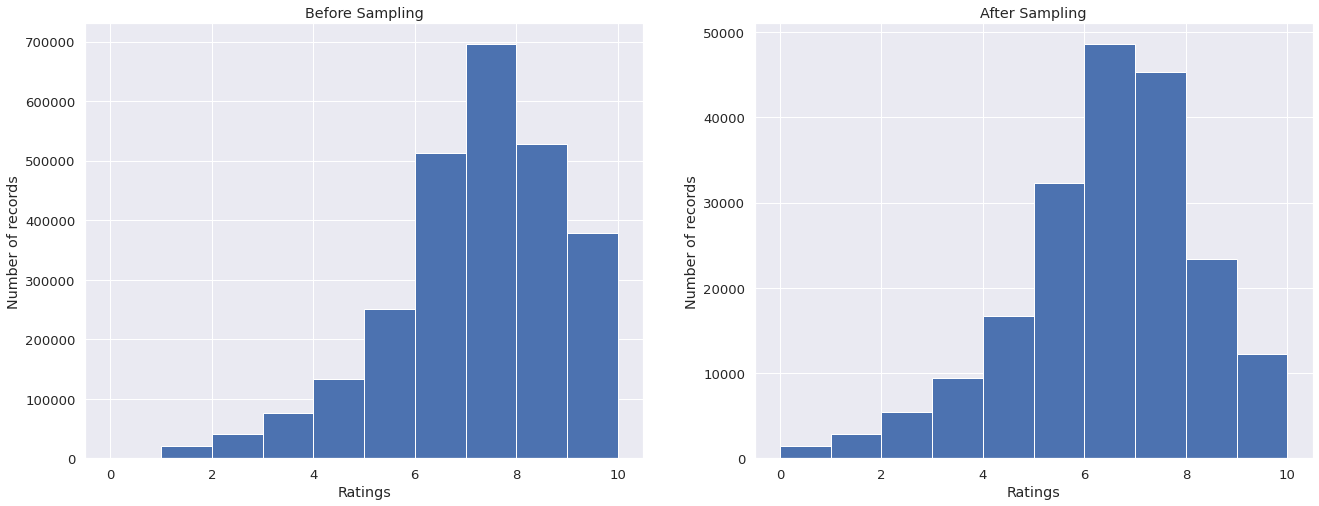

In [6]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(22,8))
ax1.hist(data['rating'])
ax1.set_title("Before Sampling")
ax1.set_xlabel("Ratings")
ax1.set_ylabel("Number of records")

ax2.hist(data.sample(frac=sample_frac)['rating'])
ax2.set_xlabel("Ratings")
ax2.set_ylabel("Number of records")
ax2.set_title("After Sampling")
plt.show()



## Preprocessing
To cut down redundant computation, the data once cleaned up will be saved as a JSON file so it can be loaded faster in subsquent executions. In this case, the saved data will be available in the `_processed` folder inside the base path. 

> The same approach will be followed in all the upcoming steps to minimize processing time and to prevent redundant computation.


### Preliminary Cleanup
1. Convert comment to lower case
2. Remove the following
  * HTML Tags
  * Punctuation
  * Links
  * Words with digits
  * Special characters
3. Eliminate words whose length is less than 3
4. Remove stopwords

In [0]:
def clean(comment):
  comment = comment.lower()
  comment = re.sub("</?\\w+/?>", "",comment)
  comment = re.sub("https?://\\w+.\\w+.\\w+", "", comment)
  comment = re.sub("('|\\d)", "", comment)
  comment = re.sub("\\W+", " ", comment)
  comment = [w for w in comment.split(" ") if len(w) >= 3]
  comment = " ".join(comment)
  return comment

In [0]:
def preprocess(data):
  # Check if cleaned data already exists
  json_path  = "{}/_processed/cleaned.json".format(base_path)
  if os.path.exists(json_path):
    print("Pre-cleaned data found in {}, loading...".format(json_path))
    del(data)
    return pd.read_json(json_path, lines=True)
  data['comment'] = data['comment'].apply(clean)
  return data

In [9]:
data = preprocess(data)
data.head()

Pre-cleaned data found in /content/drive/My Drive/colab_data/_processed/cleaned.json, loading...


,comment,rating
0,currently sits list favorite game,10.0
1,know says many plays many many uncounted liked...,10.0
2,never tire game awesome,10.0
3,probably best game ever played requires thinki...,10.0
4,fantastic game got hooked games,10.0


### Sampling
Because of the sheer volume of the data i.e. 2.6 Million records, the computation complexity can get really intense. Therefore, we will be sampling 10% of this data. 

Sampling the process of deriving a subset of the population that best resembles the trend / distribution of the population.

In [10]:
data = data.sample(frac=sample_frac, replace=False)
print("Total number of records after sampling: {:,}".format(data.shape[0]))
data.head()

Total number of records after sampling: 197,863


,comment,rating
1328395,quick easy teach friend loves puzzles loves game,8.0
940130,,7.0
249408,good game built werewolf secret voting mechani...,8.0
1723467,fun auction game whereby players use wins deve...,5.0
1338359,really love theme humour game fun gameplay,7.0


### Stemming
Stemming refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes

In this example, I will be using the `SnowballStemmer` because it is more accurate than it's counterparts i.e. `PorterStemmer`


In [11]:
def stem(comment):
  comment = [sbs.stem(w) for w in comment.split()]
  return " ".join(comment)

data["comment"] = data["comment"].apply(stem)
data.head()

,comment,rating
1328395,quick easi teach friend love puzzl love game,8.0
940130,,7.0
249408,good game built werewolf secret vote mechan bs...,8.0
1723467,fun auction game wherebi player use win develo...,5.0
1338359,realli love theme humour game fun gameplay,7.0


# Model Evaluation

At this stage, the data is pre-processed is ready for training models. In context of this problem, we will treat the rating as both continous and discrete value and evaluate Linear models and Classification models to understand which approach best fits this data.

# Classification Models
Classification techniques are very popular when it comes to dealing with text data and I will be 
Need to discretize the rating column. We will be rounding the ratings to nearest integer


In [0]:
data['rating'] = data['rating'].apply(round)

## Five fold cross validation

In [13]:
X = data['comment']
y = data['rating']
fold = 1
metrics = {
    'nb' : [],
    'nb_smooth1' : [],
    'nb_smooth2' : []
}

for train_index, test_index in kf.split(X):
  test_begin, test_end = min(test_index), max(test_index)
  print("Fold: {}".format(fold))
  fold+=1
  test = data[test_begin:test_end]
  train = data[0:test_begin].append(data[test_end:])
  X_test, y_test = test['comment'], test['rating']
  X_train, y_train = train['comment'], train['rating']
  print("\tNo. of train records : {:,}".format(len(X_train)))
  print("\tNo. of test records : {:,}".format(len(X_test)))

  # Transform to Tfidf vectors
  train_vectorizer = TfidfVectorizer()
  X_train = train_vectorizer.fit_transform(X_train)
  test_vectorizer = TfidfVectorizer(vocabulary=train_vectorizer.vocabulary_)
  X_test = test_vectorizer.fit_transform(X_test)
  
  # Naive Bayes without smoothing
  nb = MultinomialNB()
  nb.fit(X_train, y_train)
  y_nb_predicted = nb.predict(X_test)

  acc = accuracy_score(y_test,y_nb_predicted)

  metrics['nb'].append(acc)
  print("\tNaive Bayes without smoothing => accuracy: {}".format(acc))
  
  nb1 = MultinomialNB(alpha=0.1)
  nb1.fit(X_train, y_train)
  y_nb1_predicted = nb1.predict(X_test)

  acc = accuracy_score(y_test,y_nb1_predicted)
  metrics['nb_smooth1'].append(acc)
  print("\tNaive Bayes with Smoothing(alpha=0.1) => accuracy: {}".format(acc))

  nb2 = MultinomialNB(alpha=0.01)
  nb2.fit(X_train, y_train)
  y_nb2_predicted = nb2.predict(X_test)

  acc = accuracy_score(y_test,y_nb2_predicted)
  metrics['nb_smooth2'].append(acc)
  print("\tNaive Bayes with Smoothing(alpha=0.01) => accuracy: {}".format(acc))

  print("\n")
  gc.collect()

Fold: 1
	No. of train records : 158,291
	No. of test records : 39,572
	Naive Bayes without smoothing => accuracy: 0.2915445264328313
	Naive Bayes with Smoothing(alpha=0.1) => accuracy: 0.29313656120489234
	Naive Bayes with Smoothing(alpha=0.01) => accuracy: 0.29303547963206306


Fold: 2
	No. of train records : 158,291
	No. of test records : 39,572
	Naive Bayes without smoothing => accuracy: 0.29533508541392905
	Naive Bayes with Smoothing(alpha=0.1) => accuracy: 0.2969018497927828
	Naive Bayes with Smoothing(alpha=0.01) => accuracy: 0.29715455372485594


Fold: 3
	No. of train records : 158,291
	No. of test records : 39,572
	Naive Bayes without smoothing => accuracy: 0.28939654301020923
	Naive Bayes with Smoothing(alpha=0.1) => accuracy: 0.2906095218841605
	Naive Bayes with Smoothing(alpha=0.01) => accuracy: 0.2896239765490751


Fold: 4
	No. of train records : 158,292
	No. of test records : 39,571
	Naive Bayes without smoothing => accuracy: 0.2965302873316317
	Naive Bayes with Smoothing(

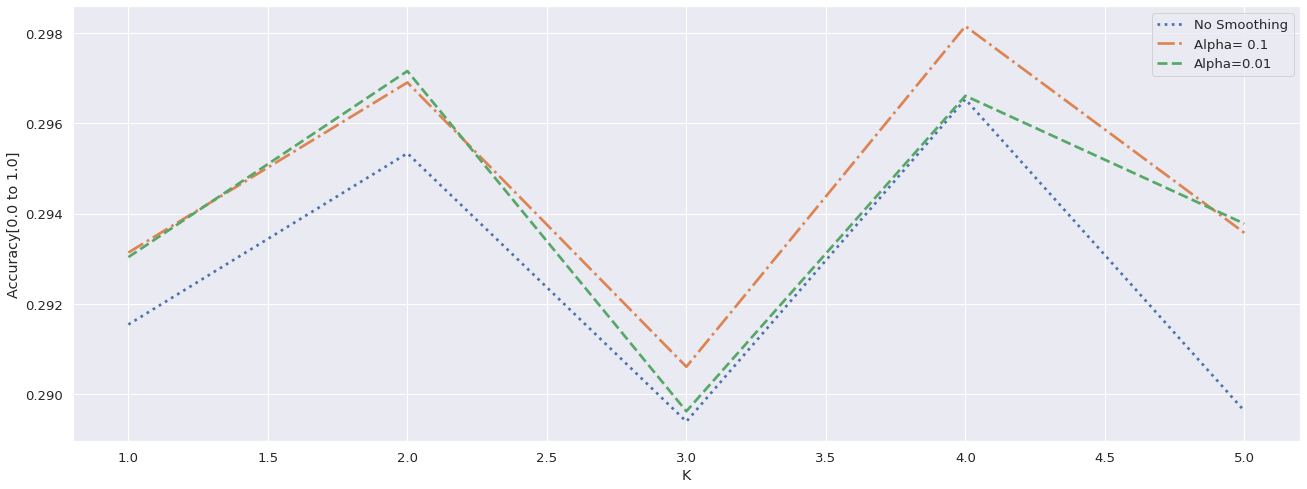

3032

In [21]:
f, ax = plt.subplots(1,1,figsize=(22,8))
k = [1,2,3,4,5]
ax.plot(k,metrics['nb'], label="No Smoothing", linestyle=":", linewidth=2.7)
ax.plot(k,metrics['nb_smooth1'], label="Alpha= 0.1", linestyle="-.", linewidth=2.7)
ax.plot(k,metrics['nb_smooth2'], label="Alpha=0.01", linestyle="--", linewidth=2.7)
ax.set_ylabel("Accuracy[0.0 to 1.0]")
ax.set_xlabel("K")
ax.legend(loc="best")
plt.show()

gc.collect()

# Linear Models
In-order to fit a linear model to our data, we first need to convert the data from text format to vectors. We will be using TF-IDF Vectorization technique for this. 

## Tf-IDF Vectorization
Stands for Term Frequency - Inverse Document Frequency. It is a numeric statistic that reflects how important a word is in a document in a corpus. Since the outcome is an numerical value, TF-IDF technique is very useful to transform text records into numerical vectors and train Linear models on them


For each word in the comments, we calculate the following


`TF(term) = No. of occurrences times term in a document/ No. of terms in document `

`IDF(term) = No. of occurrence of term in corpus / No. of documents that contain term`


For this dataset, I will be evaluating `Lasso Regression` and `Ridge Regression` since they are simple, reduce model complexity and prevent over-fitting which may result from simple `Linear Regression`.
## Lasso Regression
The Lasso is a shrinkage and selection method for linear regression. It minimizes the usual sum of squared errors, with a bound on the sum of the absolute values of the coefficients. It has connections to soft-thresholding of wavelet coefficients, forward stagewise regression, and boosting methods.

I will be fitting a `Lasso Regression` model with alpha values = `[0.1, 0.05, 0.01]` respectively using the `sklearn` library


## Ridge Regression
This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. Also known as Ridge Regression or Tikhonov regularization. This estimator has built-in support for multi-variate regression (i.e., when y is a 2d-array of shape (n_samples, n_targets)).

`Ridge regression` will also be fitted for the same alpha values as `Lasso` for fair comparison


In [15]:
X = data['comment']
y = data['rating']
fold = 1
linear_metrics = {
    "lasso": {
        0.1: {"r2":[], "mse": []},
        0.05: {"r2":[], "mse": []},
        0.01: {"r2":[], "mse": []},
        0.001: {"r2":[], "mse": []}
    },
    "ridge": {
        0.1: {"r2":[], "mse": []},
        0.05: {"r2":[], "mse": []},
        0.01: {"r2":[], "mse": []},
        0.001: {"r2":[], "mse": []}
    },
    
}
for train_index, test_index in kf.split(X):
  test_begin, test_end = min(test_index), max(test_index)
  # train_begin, train_end = min(train_index), max(train_index)
  print("Fold: {}".format(fold))
  fold+=1
  test = data[test_begin:test_end]
  train = data[0:test_begin].append(data[test_end:])
  X_test, y_test = test['comment'], test['rating']
  X_train, y_train = train['comment'], train['rating']
  print("\tNo. of train records : {:,}".format(len(X_train)))
  print("\tNo. of test records : {:,}".format(len(X_test)))

  # Transform to Tfidf vectors
  train_vectorizer = TfidfVectorizer()
  X_train = train_vectorizer.fit_transform(X_train)
  test_vectorizer = TfidfVectorizer(vocabulary=train_vectorizer.vocabulary_)
  X_test = test_vectorizer.fit_transform(X_test)
  
  for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_lasso_predicted = lasso.predict(X_test)
    r2 = r2_score(y_test, y_lasso_predicted)
    mse = mean_squared_error(y_test, y_lasso_predicted)
    linear_metrics['lasso'][alpha]['r2'].append(r2)
    linear_metrics['lasso'][alpha]['mse'].append(mse)
    print("\tLasso(alpha={}) => R2 Score: {}, Mean Squared Error: {}"\
          .format(alpha, r2, mse))

    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_ridge_predicted = ridge.predict(X_test)
    r2 = r2_score(y_test, y_ridge_predicted)
    mse = mean_squared_error(y_test, y_ridge_predicted)
    linear_metrics['ridge'][alpha]['r2'].append(r2)
    linear_metrics['ridge'][alpha]['mse'].append(mse)
    print("\tRidge(alpha={}) => R2 Score: {}, Mean Squared Error: {}"\
          .format(alpha, r2, mse))
  print("\n")
  gc.collect()

Fold: 1
	No. of train records : 158,291
	No. of test records : 39,572
	Lasso(alpha=0.1) => R2 Score: -5.35573623707819e-05, Mean Squared Error: 3.2040226198234447
	Ridge(alpha=0.1) => R2 Score: 0.2573144535651184, Mean Squared Error: 2.3794538529210505
	Lasso(alpha=0.05) => R2 Score: -5.35573623707819e-05, Mean Squared Error: 3.2040226198234447
	Ridge(alpha=0.05) => R2 Score: 0.23604284236751782, Mean Squared Error: 2.447604926366516
	Lasso(alpha=0.01) => R2 Score: 0.011802193039997633, Mean Squared Error: 3.166038561685242
	Ridge(alpha=0.01) => R2 Score: 0.18041730429098546, Mean Squared Error: 2.625820863828033


Fold: 2
	No. of train records : 158,291
	No. of test records : 39,572
	Lasso(alpha=0.1) => R2 Score: -6.347365846259834e-07, Mean Squared Error: 3.2270249177420096
	Ridge(alpha=0.1) => R2 Score: 0.2636349356997353, Mean Squared Error: 2.3762669027481134
	Lasso(alpha=0.05) => R2 Score: -6.347365846259834e-07, Mean Squared Error: 3.2270249177420096
	Ridge(alpha=0.05) => R2 Sco

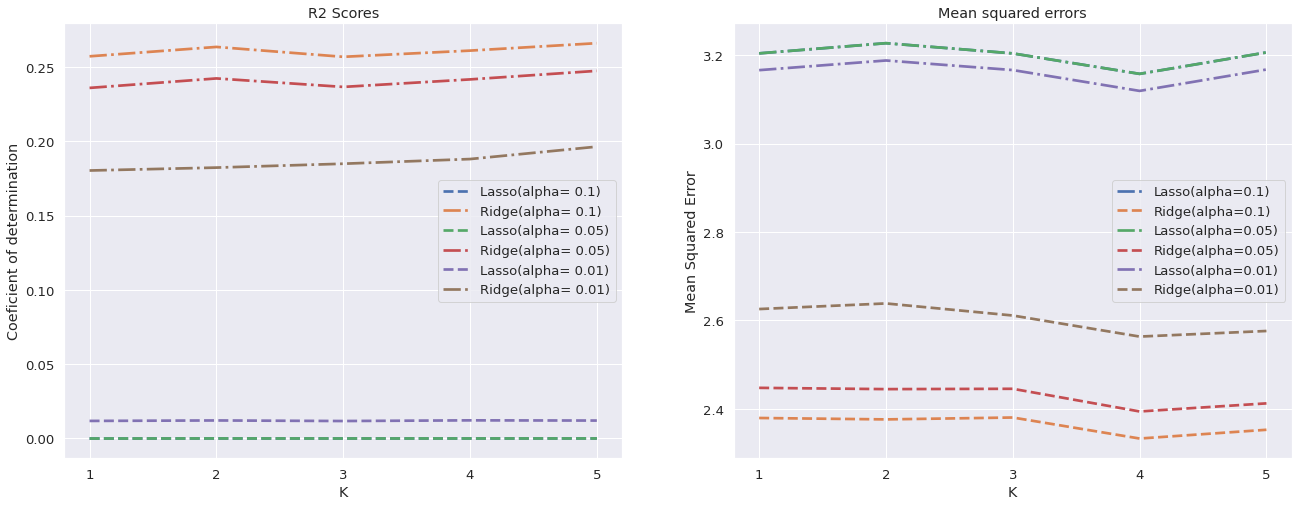

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,8))
k = [1,2,3,4,5]
for alpha in alphas:
  ax1.plot(k, linear_metrics['lasso'][alpha]['r2'], 
           label="Lasso(alpha= {})".format(alpha),
           linestyle='--',
           linewidth=2.7
           )
  ax1.plot(k, linear_metrics['ridge'][alpha]['r2'], 
           label="Ridge(alpha= {})".format(alpha),
           linestyle='-.',
           linewidth=2.7
           )
  ax1.legend(loc="best")
  ax1.set_xlabel("K")
  ax1.set_ylabel("Coeficient of determination")
  ax1.set_title("R2 Scores")
  ax1.set_xticks([1,2,3,4,5])
  ax1.grid(True)

for alpha in alphas:
  ax2.plot(k, linear_metrics['lasso'][alpha]['mse'], 
           label="Lasso(alpha={})".format(alpha),
           linestyle='-.',
           linewidth=2.7)
  ax2.plot(k,linear_metrics['ridge'][alpha]['mse'], 
           label="Ridge(alpha={})".format(alpha),
           linestyle='--',
           linewidth=2.7)
  ax2.set_title("Mean squared errors")
  ax2.legend(loc="best")
  ax2.set_xlabel("K")
  ax2.set_ylabel("Mean Squared Error")
  ax2.set_xticks([1,2,3,4,5])
  ax2.grid(True)

plt.show()





# Model selection
From the above experiments, it is clear that classification models don't work well for this data. Considering `mean squared error` as evaluation metric, the Ridge regression model with learning rate of 0.1 performed well on an average across the five fold cross validation process. 

Therefore, I will be selecting this model to train the data on and finally build the prediction app using this trained model


# Training the model

In [17]:
data = preprocess(None)
train_size = int(data.shape[0]*train_frac)

X = data['comment']
y = data['rating']
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
train_vectorizer = TfidfVectorizer()
X_train = train_vectorizer.fit_transform(X_train)
test_vectorizer = TfidfVectorizer(vocabulary=train_vectorizer.vocabulary_)
X_test = test_vectorizer.fit_transform(X_test)

model = Ridge(alpha=0.1)
model.fit(X_train, y_train)
y_model_predicted = model.predict(X_test)

mse = mean_squared_error(y_test, y_model_predicted)
print("Mean Square Error: {}".format(mse))

Pre-cleaned data found in /content/drive/My Drive/colab_data/_processed/cleaned.json, loading...
Mean Square Error: 2.138751436308403


In [0]:
pickle.dump(train_vectorizer.vocabulary_, open('{}/ridge_vocab.pkl'.format(base_path), "wb"))
pickle.dump(model, open('{}/ridge_model.pkl'.format(base_path), "wb"))

# Building the app
Now that we have evaluated which model works well for the data and successfully trained a model, it is time to create value by building a webapp that is publicly accessible which uses this trained model to predict rating. 

# App Architecture

// todo: Attach app architecture

## Backend
The backend for this application will be built using `Django`. We will be developing A REST API that accepts review as input, returns the rating predicted by using this trained model.


## Hosting for backend
I have used [heroku](https://www.heroku.com/) to host the backend for this application. Detailed steps on how to deploy a Django app on heroku is available [here](https://devcenter.heroku.com/articles/deploying-python). 

But in summary, once the Django project is properly set-up, at the project root, we need to provide 

1. requirements.txt - Contains list of libraries required by the project
2. Procfile - Describes heroku how to run the server

Once these files are created, using the [heroku-cli](https://aur.archlinux.org/packages/heroku-cli), we can deploy the app to our heroku account as shown below.

// todo: Attach heroku screenshot here. 
## Front end 
Front end for this project is developed with plain HTML, CSS and Javascript. There are several javascript libraries that offer very impressive UI. But considering the scope of this project, I have developed a simple UI which has a textbox to enter the review and a space to display the predicted rating for the given review. Ajax or Javascript's built in `XMLHttpRequest` is used to call the REST API to get the prediction and display it on the page without reloading or opening a new page.

## Hosting the front-end
For it's simplicity of use, [Netlify](https://www.netlify.com/) is used for hosting the front-end of this project. To host a website/web-app using netlify, one simply needs to link their github and netlify takes care of publishing the webpage every-time the user pushes any updates to the respective git branch. 




